In [26]:
import os
import scipy.sparse as sp_sparse
import scanpy as sc
import numpy as np
from anndata import AnnData
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
#import harmonypy as hm


folder = '../../processed_data/clean_data/'

npc = 50

df_pca = pd.read_csv(folder + 'reductions/seurat_pca.csv', index_col=0).iloc[:, :20]
df_umap = pd.read_csv(folder + 'reductions/seurat_umap_harmony%d.csv' % npc, index_col=0)

df_meta = pd.read_csv(folder + 'metadata.csv', index_col = 0)

df_meta.cluster = df_meta.cluster.astype('category')

In [2]:
df_gene = pd.read_csv(folder + 'gene_expression_v10k.csv', index_col = 0)

In [3]:
data_obj = AnnData(X = df_gene.values, 
                   var = pd.DataFrame([], index = df_gene.columns), 
                   obs = df_meta)

In [4]:
ind = (data_obj.obs.celltype == 'Mic')# | (data_obj.obs.celltype == 'Mo') #| (data_obj.obs.celltype == 'T.NK')

#data_sub = sc.AnnData(data_obj.X[ind].copy(), 
#                       obs = data_obj.obs.values[ind, ].copy(),
#                       var = data_obj.var.copy() )
data_sub = data_obj[ind]
sc.pp.filter_genes(data_sub, min_cells = int(0.01 * sum(ind)))
#data_sub.to_df().astype('int').to_csv('mic_mo_gene_expression_raw.csv')

Trying to set attribute `.var` of view, copying.


In [5]:
data_sub.shape

(3052, 5460)

In [6]:
sc.pp.normalize_total(data_sub, target_sum=1e4)
sc.pp.log1p(data_sub)
sc.pp.highly_variable_genes(data_sub, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [7]:
df_deg = pd.read_csv('../../degs/dream_v10k_knn/dream_degs.csv')
df_deg = df_deg[df_deg.CellType =='Mic'].sort_values('P.Value')

In [8]:
sgenes = sorted(set(df_deg.Gene[:500]) & set(data_sub.var.index))

In [9]:
data_sub.shape, len(sgenes)

((3052, 5460), 130)

In [10]:
#data_sub2 = sc.AnnData(data_sub[:, sgenes].X.copy(), 
#                       obs = data_sub.obs.copy(),
#                       var = data_sub[:, sgenes].var.copy() )

In [11]:
data_sub.var

,n_cells,highly_variable,means,dispersions,dispersions_norm
TIMP1,224,True,0.653068,3.189022,0.696798
MGP,230,True,0.748394,3.334160,1.032166
LINC01090,43,False,0.114722,2.901119,0.458670
F13A1,416,True,1.553394,5.537127,5.743659
RELN,48,True,0.146138,3.081167,0.949676
...,...,...,...,...,...
TMCC1-AS1,121,False,0.245544,2.523714,-0.570546
PTPN9,898,False,1.398283,2.763239,-0.482877
HPN,106,False,0.250454,2.790498,0.156996
MRPL33,286,False,0.571270,2.951254,0.147388


In [12]:
data_sub[:, data_sub.var.highly_variable].X.shape

(3052, 1282)

In [13]:
data_sub.obsm['X_pca'] = sc.tl.pca(data_sub[:, sgenes].X)
#data_sub.obsm['X_pca']  = sc.tl.pca(data_sub[:, data_sub.var.highly_variable].X, n_comps=20)
#X_pca.shape

In [14]:
#sc.pp.neighbors(data_sub, n_neighbors=15, use_rep='X_corrected')
sc.pp.neighbors(data_sub, n_neighbors=15, use_rep='X_pca')

In [15]:
sc.tl.umap(data_sub)

... storing 'subject_id' as categorical
... storing 'tissue' as categorical
... storing 'pid' as categorical
... storing 'celltype' as categorical
... storing 'clinical' as categorical


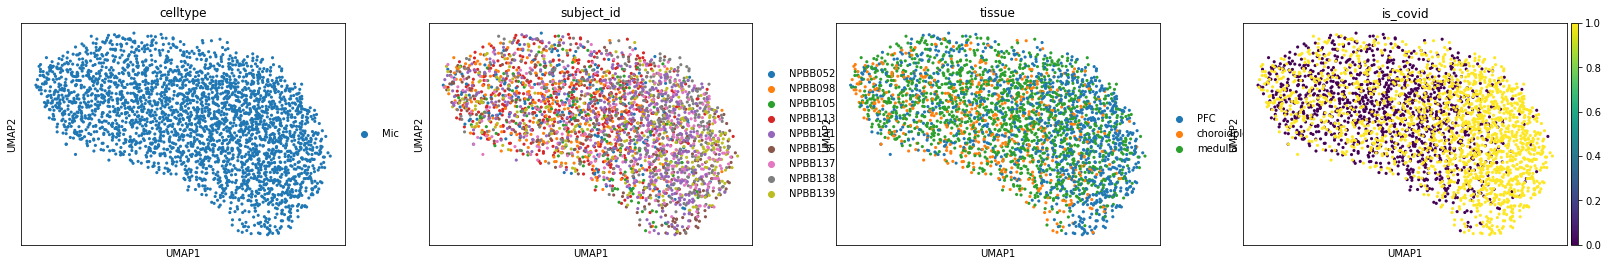

In [16]:
sc.pl.umap(data_sub, color = ['celltype', 'subject_id', 'tissue', 
                              'is_covid'])


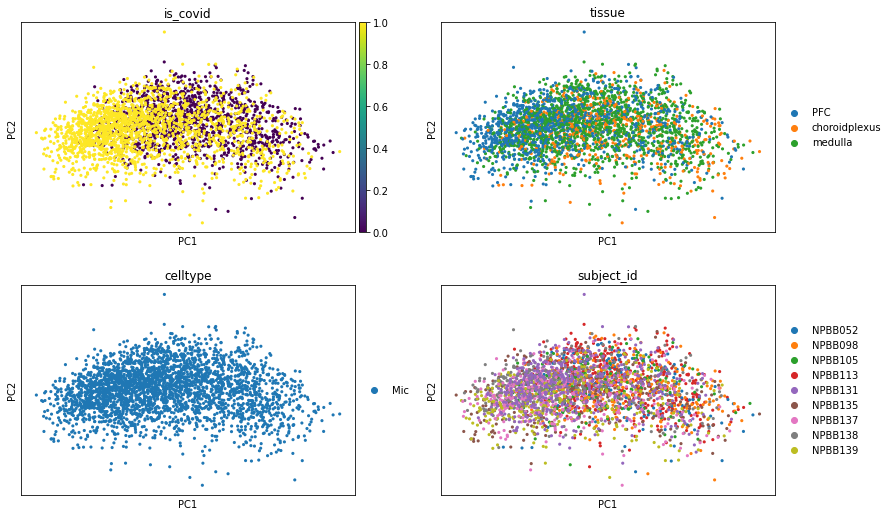

In [17]:
sc.pl.pca(data_sub, color = ['is_covid', 'tissue', 'celltype', 'subject_id'], ncols = 2)

In [20]:
sc.tl.leiden(data_sub, resolution=1)
#sc.tl.louvain(data_sub, resolution=1)

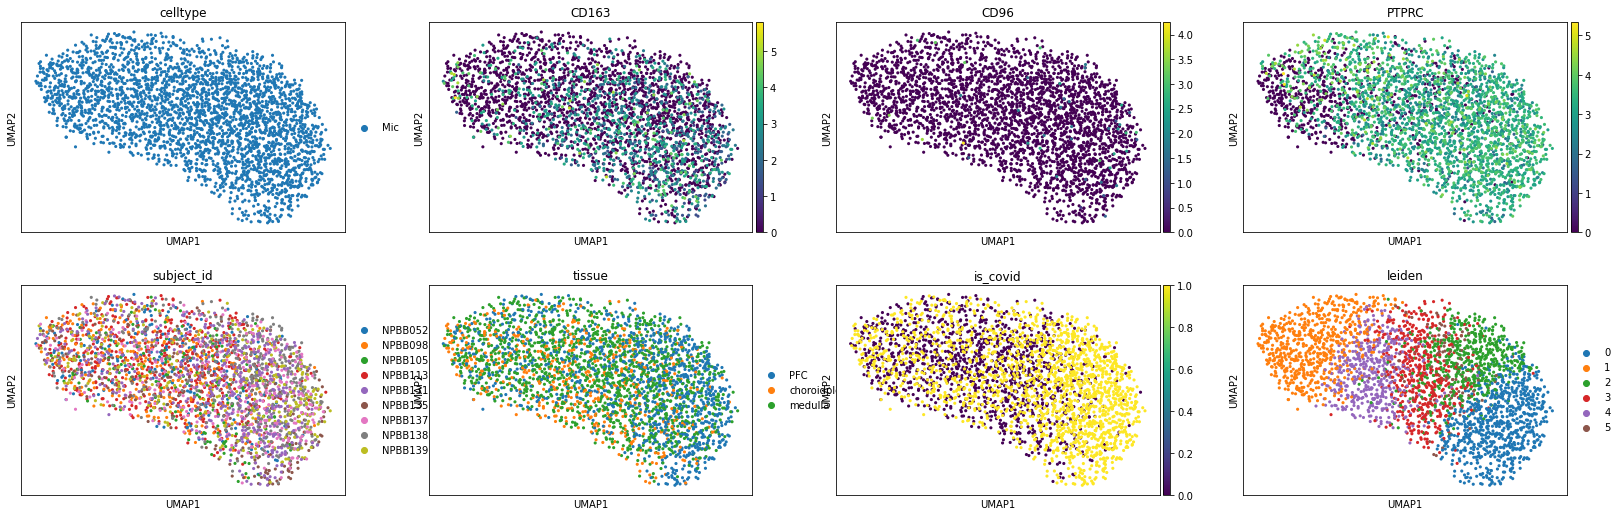

In [21]:
sc.pl.umap(data_sub, color = ['celltype', 'CD163', 'CD96', 'PTPRC',
                              'subject_id', 'tissue', 
                              'is_covid', 'leiden'])

In [ ]:
sc.pl.pca(data_sub, color = ['is_covid', 'tissue', 'celltype', 'subject_id'], ncols = 2)

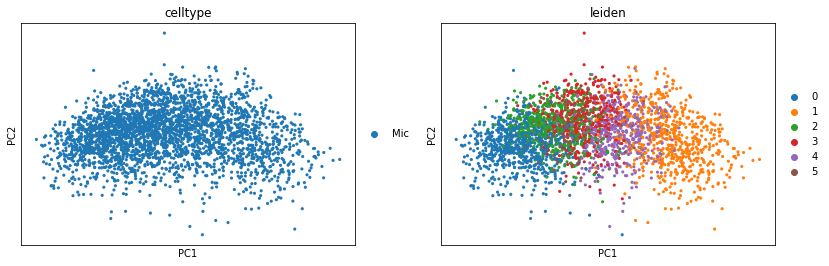

In [29]:
sc.pl.pca(data_sub, color = ['celltype', 'leiden'])

In [ ]:
for g in ['FTL', 'IRAK3', 'CD163', 'C1QA', 'C1QB', 'CD14',
                              'CCL2', 'CCL4', 'FCGR1A']:
    t0 = data_sub.obsm['X_pca'][:, 0]
    t1 = data_sub[:, g].X[:, 0]
    l1 = data_sub.obs.is_covid.values
    
    plt.plot(t0[l1 == 0], t1[l1 == 0], 'b.')
    plt.plot(t0[l1 == 1], t1[l1 == 1], 'r.')
    #p0 = gaussian_kde(t0[data_sub.obs.is_covid == 0])
    plt.title(g)
    plt.show()

In [ ]:
from sklearn.kernel_ridge import KernelRidge
clf = KernelRidge(10., kernel = 'rbf')
t0 = data_sub.obsm['X_pca'][:, 0]
#cell_order = np.argsort(t0)
xx = np.linspace(-6, 10, 200)
for g in ['FTL', 'IRAK3', 'CD163', 'C1QA', 'C1QB', 'CD14',
                              'CCL2', 'CCL4', 'FCGR1A']:
    
    t1 = data_sub[:, g].X[:, 0]
    l1 = data_sub.obs.is_covid.values
    
    #plt.plot(t0[l1 == 0], t1[l1 == 0], 'b.')
    #plt.plot(t0[l1 == 1], t1[l1 == 1], 'r.')
    #p0 = gaussian_kde(t1[cell_order])
    clf.fit(t0[:,None], t1[:,None])
    v0 = clf.predict(xx[:,None])
    plt.plot(t0, t1, '.')
    plt.plot(xx, v0[:,0])

    plt.title(g)
    plt.show()

In [ ]:
from scipy.stats import gaussian_kde
t0 = data_sub.obsm['X_pca'][:, 0]
p0 = gaussian_kde(t0[data_sub.obs.is_covid == 0])
p1 = gaussian_kde(t0[data_sub.obs.is_covid == 1])
xx = np.linspace(-6, 4, 200)

In [ ]:
v1 = p1(xx)
v0 = p0(xx)
plt.plot(xx, v1 / (v0 + v1))
plt.xlabel('pc1', fontsize = 12)
plt.ylabel('relative density of covid v.s ctrl', fontsize = 12)
plt.show()
plt.plot(xx, v1, 'r')
plt.plot(xx, v0, 'b')

In [ ]:
from collections import Counter
Counter(item.leiden)

In [ ]:
pd.DataFrame(data_sub.obsm['X_umap'], columns = ['umap1', 'umap2']).to_csv('./mic_mo_diff_umap.csv', index = False)

In [25]:
data_sub.obs.to_csv('mic_diff_meta.csv')

In [28]:
data_sub[:, sgenes].to_df().to_csv('./data/mic_diff_gene_expression.csv')

In [ ]:
pd.DataFrame(data_sub.obsm['X_pca'][:, 0], columns = ['pc1']).to_csv('./mic_mo_diff_pc1.csv', index = False)

In [24]:
data_sub.obs

,subject_id,tissue,tissue_id,pid,cluster,celltype,clinical,is_covid,leiden
AAATGGAGTGTAGCAG-frozen-COVID-set1-A,NPBB113,medulla,3,set1-A,7,Mic,Ctrl,0,5
AACACACAGTCTAACC-frozen-COVID-set1-A,NPBB113,medulla,3,set1-A,7,Mic,Ctrl,0,4
AACCAACCATTGGATC-frozen-COVID-set1-A,NPBB113,medulla,3,set1-A,7,Mic,Ctrl,0,4
AACCTGAGTCCGGACT-frozen-COVID-set1-A,NPBB113,choroidplexus,6,set1-A,7,Mic,Ctrl,0,3
AACGGGAGTGCTATTG-frozen-COVID-set1-A,NPBB113,medulla,3,set1-A,7,Mic,Ctrl,0,2
...,...,...,...,...,...,...,...,...,...
TTTACGTTCAAGAATG-frozen-COVID-set9-B,NPBB131,medulla,3,set9-B,7,Mic,COVID_HIV,1,0
TTTACTGCAGTGTATC-frozen-COVID-set9-B,NPBB131,PFC,1,set9-B,7,Mic,COVID_HIV,1,2
TTTCCTCAGACGATAT-frozen-COVID-set9-B,NPBB131,medulla,4,set9-B,7,Mic,COVID_HIV,1,3
TTTGGAGTCCGGGACT-frozen-COVID-set9-B,NPBB131,PFC,2,set9-B,7,Mic,COVID_HIV,1,4


In [34]:
pd.DataFrame(data_sub.obsm['X_pca'][:, :10], columns = ['pc%d' % i for i in range(10)]).to_csv('./mic_diff_pca.csv', index = False)